## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests

In [2]:
pd.options.mode.chained_assignment = None

## Загрузка и чтение датафрейма

In [2]:
public_url = 'https://disk.yandex.ru/d/kSXgLjlb37VRCg'
api_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
params = {'public_key':public_url}
response = requests.get(api_url, params=params)
response.raise_for_status()
download_url = response.json()['href']
report = pd.read_csv(download_url)
report.head()

,ComponentID,OperationID,PhaseID,Source,SourceFileName,Timestamp
0,id_stage,1a7f81f9-0575-4fba-aa4b-efb71bf51830,stage_json_update,System_E,2025-08-07-09-19-47-439_0.txt,2025-07-08-05-05-00-003
1,id_stage,434688eb-b563-486a-8b8a-9fafce2d50aa,stage_find,System_E,2025-08-07-09-19-47-444_1.txt,2025-07-08-05-05-00-004
2,id_stage,f0e8b9af-ca32-4085-b109-fad580372463,stage_after_cons,System_E,2025-08-07-09-19-47-444_2.txt,2025-07-08-05-05-00-006
3,id_stage,10d09e69-d0c7-49cd-af3b-2e5f3a303cdc,stage_before_cons,System_Z,2025-08-07-09-19-47-445_3.txt,2025-07-08-05-05-00-013
4,id_stage,8f4b3e9a-0739-4482-aa96-024c18c087ec,stage_after_cons,System_ES,2025-08-07-09-19-47-445_4.txt,2025-07-08-05-05-00-014


In [4]:
#копия датафрейма с нужными столбцами
report_copy = report[['OperationID', 'PhaseID', 'Timestamp']]
report_copy.head()

,OperationID,PhaseID,Timestamp
0,1a7f81f9-0575-4fba-aa4b-efb71bf51830,stage_json_update,2025-07-08-05-05-00-003
1,434688eb-b563-486a-8b8a-9fafce2d50aa,stage_find_dublicate,2025-07-08-05-05-00-004
2,f0e8b9af-ca32-4085-b109-fad580372463,stage_flk2,2025-07-08-05-05-00-006
3,10d09e69-d0c7-49cd-af3b-2e5f3a303cdc,stage_flk1,2025-07-08-05-05-00-013
4,8f4b3e9a-0739-4482-aa96-024c18c087ec,stage_flk2,2025-07-08-05-05-00-014


## Обработка и подготовка датафрейма

In [5]:
report_copy.dtypes

OperationID    object
PhaseID        object
Timestamp      object
dtype: object

In [6]:
report_copy.isna().sum()

OperationID    0
PhaseID        0
Timestamp      0
dtype: int64

In [7]:
# Перевод столбца Timestamp в тип datetime
report_copy['Timestamp'] = pd.to_datetime(report_copy['Timestamp'], format='%Y-%m-%d-%H-%M-%S-%f')

In [8]:
# Сбор списков фаз обработки профилей
initial_phase = ['stage_sudir2', 
                 'ulk_profile_in', 
                 'ESIA_message_profile_in', 
                 'MFC_message_profile_in', 
                 'FATALOIV_message_profile_in',
                 'ROGDOIV_message_profile_in',
                 'BRAKZAKOIV_message_profile_in',
                 'BRAKRASTOIV_message_profile_in', 
                 'PARENTOIV_message_profile_in',
                 'FATAL_message_profile_in',
                 'ROGD_message_profile_in',
                 'PERNAME_message_profile_in',
                 'ERL_message_profile_in',
                 'RR_message_profile_in']

block_phase = ['lock_start', 'lock_end']

flk_1_phase = ['stage_to_flk1', 'stage_flk1']

dublicate_search_phase = ['stage_get_dublicate', 
                          'stage_ud_get_json', 
                          'stage_find_dublicate', 
                          'stage_ud_find_json']

flk_2_phase = ['stage_to_flk2', 'stage_flk2']

saving_profile_phase = ['stage_json_insert', 
                        'ud_response_insert', 
                        'stage_json_update', 
                        'ud_response_update']

releasing_lock_phase = ['unlock_start', 'unlock_end']

ending_phase = ['stage_sudir2_resp', 
                'ulk_profile_out', 
                'ESIA_message_profile_out', 
                'MFC_message_profile_out', 
                'FATALOIV_message_profile_out',
                'ROGDOIV_message_profile_out', 
                'BRAKZAKOIV_message_profile_out', 
                'BRAKRASTOIV_message_profile_out',
                'PARENTOIV_message_profile_out', 
                'FATAL_message_profile_out', 
                'ROGD_message_profile_out',
                'PERNAME_message_profile_out',
                'ERL_message_profile_out',
                'RR_message_profile_out']

validation_phase = ['stage_ksrd_valid_save', 
                    'extval_from_ksrd_asur_msg'] 

ignore_phase = ['locked_by_merge'] # ошибка слияния, игнорируется

error_business_phase = ['skip_new_deleted', 'stage_cannot_del_val', 'stage_update_rip']

error_phase = ['exception', 'stoplist_response', 'stoplist_response_org']

In [9]:
# Поиск фаз, не описанных в ТЗ
unknow_phase = []
all_phase = (initial_phase + 
             block_phase + 
             flk_1_phase + 
             dublicate_search_phase +
             flk_2_phase + 
             saving_profile_phase + 
             releasing_lock_phase + 
             ending_phase + 
             validation_phase +
             ignore_phase + 
             error_business_phase +
             error_phase)
for phase in report_copy['PhaseID']:
    if phase in all_phase:
        continue
    else:
        if phase in unknow_phase:
            continue
        else:
            unknow_phase.append(phase)

unknow_phase

['ESIA_message_out',
 'ESIA_message_in',
 'extval_result',
 'BRAKZAKOIV_message_out',
 'BRAKZAKOIV_message_in',
 'BRAKRASTOIV_message_out',
 'BRAKRASTOIV_message_in',
 'PARENTOIV_message_in',
 'PARENTOIV_message_out',
 'MFC_message_in',
 'MFC_message_out']

In [10]:
# Найдены фазы, не описанные в ТЗ. Уточнили, к каким стадиям обработки относятся данные фазы, добавили в списки
validation_phase += [unknow_phase[2]]

ignore_phase = (ignore_phase + 
               [unknow_phase[1]] +
               [unknow_phase[4]] + 
               [unknow_phase[6]] + 
               [unknow_phase[7]] + 
               [unknow_phase[9]] +
               [unknow_phase[0]] + 
               [unknow_phase[3]] + 
               [unknow_phase[5]] + 
               [unknow_phase[8]] + 
               [unknow_phase[10]])

In [11]:
# Ищем профили с ошибкой 1,собираем профили в отдельный лист
error_report = report_copy[report_copy['PhaseID'].isin(error_phase)]
operation_id_errors = error_report['OperationID'].to_list()

In [12]:
# Сохраняем информацию по профилям с ошибкой в отдельный датафрейм
error_report.to_csv('error_report.csv')

In [13]:
# Удаляем профили с ошибкой из основного датафрейма
report_copy = report_copy[~report_copy['OperationID'].isin(operation_id_errors)]

In [14]:
# Удаляем обрезанные профили
profile_with_in = report_copy[report_copy['PhaseID'].isin(initial_phase)].OperationID.to_list()
report_copy = report_copy[report_copy['OperationID'].isin(profile_with_in)]

In [15]:
# удаляем профили с бизнес-ошибками, эти профили не учитываем
profile_error_business = report_copy[report_copy['PhaseID'].isin(error_business_phase)].OperationID.to_list()
report_copy = report_copy[~report_copy['OperationID'].isin(profile_error_business)]

In [16]:
# Вычислим время конечной фазы у каждого профиля
end_time = report_copy[report_copy['PhaseID'].isin(ending_phase)] \
           .groupby(['OperationID', 'PhaseID'], as_index=False) \
           .agg({'Timestamp':'max'})[['OperationID', 'Timestamp']]
end_time.rename(columns={'Timestamp':'max_time'}, inplace=True)

# Соединим с основной таблицей
report_copy = pd.merge(report_copy, end_time, how='left', on='OperationID')

In [17]:
# найдем id где были фазы валидации после _out, это понадобится для кода ошибки
report_copy_error_2 = report_copy[(report_copy['PhaseID'].isin(validation_phase)) & (report_copy['Timestamp'] > report_copy['max_time'])]
operation_id_error_2 = list(report_copy_error_2.OperationID.unique())

In [18]:
report_copy = report_copy[report_copy['Timestamp'] <= report_copy['max_time']] \
             .drop_duplicates(subset=['OperationID', 'PhaseID', 'Timestamp'])

In [19]:
report_copy = report_copy[['OperationID', 'PhaseID', 'Timestamp']]

In [20]:
# теперь уберем фазы, которые не влияют на ошибки, но игнорируются при рассчетах
report_copy_clean = report_copy[~report_copy['PhaseID'].isin(ignore_phase)]
report_copy_clean = report_copy_clean[~report_copy_clean['PhaseID'].isin(validation_phase)]

In [21]:
ignore_phase

['locked_by_merge',
 'ESIA_message_in',
 'BRAKZAKOIV_message_in',
 'BRAKRASTOIV_message_in',
 'PARENTOIV_message_in',
 'MFC_message_in',
 'ESIA_message_out',
 'BRAKZAKOIV_message_out',
 'BRAKRASTOIV_message_out',
 'PARENTOIV_message_out',
 'MFC_message_out']

In [22]:
report_copy_clean.drop([907, 908, 910, 911], axis=0, inplace=True)

Получили чистый датафрейм без профилей с ошибкой, без обрезанных профилей и т.д. Теперь проведем необходимые преобразования для расчета длительности фаз

## Расчет длительности фаз

In [23]:
# добавляем столбец, который считает количество повторяющихся фаз
report_copy_clean['PhaseID_num'] = report_copy_clean.groupby(['OperationID', 'PhaseID']).cumcount()

In [24]:
# функция, которая создает новый столбец с названием этапа у каждой фазы
# т.к. у фаз поиска дубликатов и сохранения профиля есть 2 версии течения, для каждой будет свое кодовое название
def get_phase(row):
    if row['PhaseID'] in initial_phase:
        if row['PhaseID_num'] == 0:
            return 'initial_phase'
        else:
            return f"initial_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in ending_phase:
        if row['PhaseID_num'] == 0:
            return 'ending_phase'
        else:
            return f"ending_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in block_phase:
        if row['PhaseID_num'] == 0:
            return 'block_phase'
        else:
            return f"block_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in flk_1_phase:
        if row['PhaseID_num'] == 0:
            return 'flk_1_phase'
        else:
            return f"flk_1_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in dublicate_search_phase:
        if '_get' in row['PhaseID']:
            if row['PhaseID_num'] == 0:
                return 'dublicate_search_get_phase'
            else:
                return f"dublicate_search_get_phase_{row['PhaseID_num']}"
        elif '_find_' in row['PhaseID']:
            if row['PhaseID_num'] == 0:
                return 'dublicate_search_find_phase'
            else:
                return f"dublicate_search_find_phase_{row['PhaseID_num']}"
            
    elif row['PhaseID'] in flk_2_phase:
        if row['PhaseID_num'] == 0:
            return 'flk_2_phase'
        else:
            return f"flk_2_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in saving_profile_phase:
        if 'insert' in row['PhaseID']:
            if row['PhaseID_num'] == 0:
                return 'saving_profile_insert_phase'
            else:
                return f"saving_profile_insert_phase_{row['PhaseID_num']}"
        elif 'update' in row['PhaseID']:
            if row['PhaseID_num'] == 0:
                return 'saving_profile_update_phase'
            else:
                return f"saving_profile_update_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in releasing_lock_phase:
        if row['PhaseID_num'] == 0:
            return 'releasing_lock_phase'
        else:
            return f"releasing_lock_phase_{row['PhaseID_num']}"


In [25]:
report_copy_clean['Phase'] = report_copy_clean.apply(get_phase, axis=1)

In [26]:
# сортировка датафрейма
sorted_report = report_copy_clean.sort_values(by=['OperationID', 'Timestamp'])[['OperationID', 'PhaseID', 'Timestamp', 'Phase']]

In [27]:
sorted_report.head(10)

,OperationID,PhaseID,Timestamp,Phase
787588,000048ff-1ce7-42d1-bd50-64b540d75054,ESIA_message_profile_in,2025-07-08 06:02:07.183,initial_phase
787601,000048ff-1ce7-42d1-bd50-64b540d75054,lock_start,2025-07-08 06:02:07.227,block_phase
787603,000048ff-1ce7-42d1-bd50-64b540d75054,lock_end,2025-07-08 06:02:07.231,block_phase
787609,000048ff-1ce7-42d1-bd50-64b540d75054,stage_to_flk1,2025-07-08 06:02:07.246,flk_1_phase
787829,000048ff-1ce7-42d1-bd50-64b540d75054,stage_flk1,2025-07-08 06:02:07.760,flk_1_phase
787839,000048ff-1ce7-42d1-bd50-64b540d75054,stage_find_dublicate,2025-07-08 06:02:07.778,dublicate_search_find_phase
788037,000048ff-1ce7-42d1-bd50-64b540d75054,stage_ud_find_json,2025-07-08 06:02:08.635,dublicate_search_find_phase
788135,000048ff-1ce7-42d1-bd50-64b540d75054,stage_to_flk2,2025-07-08 06:02:08.764,flk_2_phase
788265,000048ff-1ce7-42d1-bd50-64b540d75054,stage_flk2,2025-07-08 06:02:08.938,flk_2_phase
788278,000048ff-1ce7-42d1-bd50-64b540d75054,stage_json_update,2025-07-08 06:02:08.979,saving_profile_update_phase


In [28]:
# Фильтруем в отдельный датасет окончание фазы поиска и начало фазы флк2 для рассчета фазы merge
flk2_phase_df = sorted_report[(sorted_report['PhaseID'].apply(lambda x: x in 'stage_to_flk2'))]
dubl_phase_df = sorted_report[sorted_report['PhaseID'].apply(lambda x: x in 'stage_ud_get_json' or x in 'stage_ud_find_json')]

# Еще раз фильтруем последнюю фазу поиска и первую фазу флк2, если их у кого-то несколько
flk2_phase_df = flk2_phase_df.groupby(['OperationID', 'PhaseID'], as_index=False).agg({'Timestamp':'min'})
dubl_phase_df = dubl_phase_df.groupby(['OperationID', 'PhaseID'], as_index=False).agg({'Timestamp':'max'})

In [29]:
# Соединяем эти данные
merge_phase_df = pd.concat([flk2_phase_df, dubl_phase_df], axis=0, ignore_index=True)

In [30]:
merge_phase_df['Phase'] = 'merge_phase'

In [31]:
merge_phase_df = merge_phase_df.sort_values(by=['OperationID', 'Timestamp'])
merge_phase_df.head()

,OperationID,PhaseID,Timestamp,Phase
125877,000048ff-1ce7-42d1-bd50-64b540d75054,stage_ud_find_json,2025-07-08 06:02:08.635,merge_phase
0,000048ff-1ce7-42d1-bd50-64b540d75054,stage_to_flk2,2025-07-08 06:02:08.764,merge_phase
125878,0001b3a3-bfe7-475a-8af9-e7d48b61696d,stage_ud_find_json,2025-07-08 06:07:41.317,merge_phase
1,0001b3a3-bfe7-475a-8af9-e7d48b61696d,stage_to_flk2,2025-07-08 06:07:41.444,merge_phase
125879,00023160-aba4-41f1-aece-7af0bfbf0087,stage_ud_find_json,2025-07-08 06:29:29.315,merge_phase


In [32]:
merge_phase_df['time_diff'] = merge_phase_df.groupby(['OperationID'])['Timestamp'].diff()

In [33]:
merge_phase_df.dropna(inplace=True)

In [34]:
sorted_report = pd.concat([sorted_report, merge_phase_df], ignore_index=True)

In [35]:
# создаем столбец с разницей во времени между фазами. Входную и выходную фазу пока не учитываем
sorted_report['time_diff'] = sorted_report.groupby(['OperationID', 'Phase'])['Timestamp'].diff()

In [36]:
sorted_report.head()

,OperationID,PhaseID,Timestamp,Phase,time_diff
0,000048ff-1ce7-42d1-bd50-64b540d75054,ESIA_message_profile_in,2025-07-08 06:02:07.183,initial_phase,NaT
1,000048ff-1ce7-42d1-bd50-64b540d75054,lock_start,2025-07-08 06:02:07.227,block_phase,NaT
2,000048ff-1ce7-42d1-bd50-64b540d75054,lock_end,2025-07-08 06:02:07.231,block_phase,0 days 00:00:00.004000
3,000048ff-1ce7-42d1-bd50-64b540d75054,stage_to_flk1,2025-07-08 06:02:07.246,flk_1_phase,NaT
4,000048ff-1ce7-42d1-bd50-64b540d75054,stage_flk1,2025-07-08 06:02:07.760,flk_1_phase,0 days 00:00:00.514000


In [37]:
# отдельно добавляем в time_diff дату начала и дату конца обработки профиля
sorted_report['time_diff'] = np.where((sorted_report['Phase'] == 'initial_phase') | (sorted_report['Phase'] == 'ending_phase'), 
                                     sorted_report['Timestamp'],
                                     sorted_report['time_diff'])

In [38]:
# удалим дубликаты названий фаз
report_for_pivot = sorted_report.dropna(subset=['time_diff']).reset_index()

In [39]:
report_for_pivot.isna().sum()

index          0
OperationID    0
PhaseID        0
Timestamp      0
Phase          0
time_diff      0
dtype: int64

In [40]:
# сводная таблица
report_pivot = sorted_report \
              .dropna(subset=['time_diff']) \
              .reset_index() \
              .pivot(index='OperationID', columns='Phase', values='time_diff')

In [41]:
# ищем полное время обработки профиля по тз
report_pivot['total_time'] = report_pivot['ending_phase'] - report_pivot['initial_phase']

In [42]:
report_pivot.head(5)

Phase,block_phase,block_phase_1,block_phase_2,block_phase_3,block_phase_4,block_phase_5,block_phase_6,dublicate_search_find_phase,dublicate_search_find_phase_1,dublicate_search_find_phase_2,...,flk_2_phase_8,initial_phase,merge_phase,releasing_lock_phase,releasing_lock_phase_1,saving_profile_insert_phase,saving_profile_insert_phase_1,saving_profile_update_phase,saving_profile_update_phase_1,total_time
OperationID,,,,,,,,,,,,,,,,,,,,,
000048ff-1ce7-42d1-bd50-64b540d75054,1970-01-01 00:00:00.004,NaT,NaT,NaT,NaT,NaT,NaT,1970-01-01 00:00:00.857,NaT,NaT,...,NaT,2025-07-08 06:02:07.183,NaT,1970-01-01 00:00:00.005,NaT,NaT,NaT,1970-01-01 00:00:03.218,NaT,0 days 00:00:05.064000
0001b3a3-bfe7-475a-8af9-e7d48b61696d,1970-01-01 00:00:00.005,NaT,NaT,NaT,NaT,NaT,NaT,1970-01-01 00:00:00.303,NaT,NaT,...,NaT,2025-07-08 06:07:40.491,NaT,1970-01-01 00:00:00.005,NaT,1970-01-01 00:00:08.107,NaT,NaT,NaT,0 days 00:00:09.208000
0001f0bd-2cfd-41f1-a77c-ca04b2ac482e,1970-01-01 00:00:00.004,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,2025-07-08 05:41:44.824,NaT,1970-01-01 00:00:00.005,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00.285000
00023160-aba4-41f1-aece-7af0bfbf0087,1970-01-01 00:00:00.005,NaT,NaT,NaT,NaT,NaT,NaT,1970-01-01 00:00:00.048,1970-01-01 00:00:00.045,NaT,...,NaT,2025-07-08 06:29:28.626,NaT,1970-01-01 00:00:00.004,NaT,1970-01-01 00:00:02.883,NaT,NaT,NaT,0 days 00:00:03.974000
000280b8-7d81-4c14-a5d1-c925bbdd234b,1970-01-01 00:00:00.004,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,2025-07-08 07:02:24.475,NaT,1970-01-01 00:00:00.005,NaT,NaT,NaT,1970-01-01 00:00:03.459,NaT,0 days 00:00:06.929000


In [43]:
#переводим все колонки в тип timedelta
for col in report_pivot.columns:
    if report_pivot[col].dtypes != 'timedelta64[ns]':
        report_pivot[col] = report_pivot[col] - pd.Timestamp('1970-01-01')

#столбцы с временем начальной и конечной фазы больше не нужны
report_pivot = report_pivot.drop(columns=['ending_phase', 'initial_phase'])

In [44]:
# считаем количество секунд
for col in report_pivot.columns:
    report_pivot[col] = report_pivot[col].dt.total_seconds()

In [45]:
report_pivot_copy = report_pivot.reset_index()

In [46]:
# создадим столбец с типом обработки: . **NoSave** — неполная обработка: только ФЛК1 и Поиски **ToUDEnd** — полная обработка: все этапы.
def get_processing_type(row):
     if (pd.notna(row['flk_2_phase']) and 
        (pd.notna(row['saving_profile_insert_phase']) or pd.notna(row['saving_profile_update_phase'])) and 
         pd.notna(row['releasing_lock_phase'])):
        return 'ToUDEnd'
     else:
        return 'NoSave'

In [47]:
report_pivot_copy['processing_type'] = report_pivot_copy.apply(get_processing_type, axis=1)

## Форматирование выходного CSV

In [48]:
# Преобразование широкой таблицы обратно в длинную
long_report = report_pivot_copy.melt(id_vars=['OperationID', 'processing_type'], value_name='Phase_time')

long_report_sort = long_report.dropna().reset_index(drop=True).sort_values(by=['OperationID', 'Phase'])


Убираем постфиксы у фаз, они больше не нужны

In [49]:
def new_phase_name(row):
    if row['Phase'].startswith('block'):
        return 'block_phase'
    elif row['Phase'].startswith('flk_1'):
        return 'flk_1_phase'
    elif row['Phase'].startswith('flk_2'):
        return 'flk_2_phase'
    elif row['Phase'].startswith('dublicate_search_find'):
        return 'dublicate_search_find_phase'
    elif row['Phase'].startswith('dublicate_search_get'):
        return 'dublicate_search_get_phase'
    elif row['Phase'].startswith('saving_profile_insert'):
        return 'saving_profile_insert_phase'
    elif row['Phase'].startswith('saving_profile_update'):
        return 'saving_profile_update_phase'
    elif row['Phase'].startswith('releasing_lock'):
        return 'releasing_lock_phase'
    elif row['Phase'] == 'merge_phase':
        return row['Phase']
    elif row['Phase'] == 'total_time':
        return row['Phase']

In [50]:
long_report_sort['Phase'] = long_report_sort.apply(new_phase_name, axis=1)

Теперь добавим следующую информацию: название стартовой фазы, название конечной фазы, код ошибки

In [51]:
names_of_initial_phase = report_copy_clean.query('Phase == "initial_phase"')[['OperationID', 'PhaseID']]
names_of_ending_phase = report_copy_clean.query('Phase == "ending_phase"')[['OperationID', 'PhaseID']]

In [52]:
# Добавляем в основной csv названия начальной и конечной фазы
long_report = pd.merge(long_report_sort, names_of_initial_phase, on='OperationID')
long_report = pd.merge(long_report, names_of_ending_phase, on='OperationID')

In [53]:
long_report.rename(columns=({'PhaseID_x':'Name_of_initial_phase', 'PhaseID_y':'Name_of_ending_phase'}), inplace=True)

In [54]:
# Добавляем в основной csv коды ошибок: 0 - без ошибок, 2 - валидация после _out, профили с ошибкой 1 собраны в отдельный фрейм
long_report['error_code'] = long_report['OperationID'].apply(lambda x: 2 if x in operation_id_error_2 else 0)

In [55]:
long_report.head()

,OperationID,processing_type,Phase,Phase_time,Name_of_initial_phase,Name_of_ending_phase,error_code
0,000048ff-1ce7-42d1-bd50-64b540d75054,ToUDEnd,block_phase,0.004,ESIA_message_profile_in,ESIA_message_profile_out,0
1,000048ff-1ce7-42d1-bd50-64b540d75054,ToUDEnd,dublicate_search_find_phase,0.857,ESIA_message_profile_in,ESIA_message_profile_out,0
2,000048ff-1ce7-42d1-bd50-64b540d75054,ToUDEnd,flk_1_phase,0.514,ESIA_message_profile_in,ESIA_message_profile_out,0
3,000048ff-1ce7-42d1-bd50-64b540d75054,ToUDEnd,flk_2_phase,0.174,ESIA_message_profile_in,ESIA_message_profile_out,0
4,000048ff-1ce7-42d1-bd50-64b540d75054,ToUDEnd,releasing_lock_phase,0.005,ESIA_message_profile_in,ESIA_message_profile_out,0


In [56]:
output_report = long_report.copy()

## Сохранение выходного CSV-отчета

In [57]:
output_report.to_csv('Output_report.csv', index=False, sep=';')

In [58]:
output_report.head()

,OperationID,processing_type,Phase,Phase_time,Name_of_initial_phase,Name_of_ending_phase,error_code
0,000048ff-1ce7-42d1-bd50-64b540d75054,ToUDEnd,block_phase,0.004,ESIA_message_profile_in,ESIA_message_profile_out,0
1,000048ff-1ce7-42d1-bd50-64b540d75054,ToUDEnd,dublicate_search_find_phase,0.857,ESIA_message_profile_in,ESIA_message_profile_out,0
2,000048ff-1ce7-42d1-bd50-64b540d75054,ToUDEnd,flk_1_phase,0.514,ESIA_message_profile_in,ESIA_message_profile_out,0
3,000048ff-1ce7-42d1-bd50-64b540d75054,ToUDEnd,flk_2_phase,0.174,ESIA_message_profile_in,ESIA_message_profile_out,0
4,000048ff-1ce7-42d1-bd50-64b540d75054,ToUDEnd,releasing_lock_phase,0.005,ESIA_message_profile_in,ESIA_message_profile_out,0


## Расчет метрик

Посчитаем среднее, медиану и среднеквадратичное отклонение для каждой из фаз

In [59]:
phase_metrics = output_report \
    .groupby('Phase', as_index=False) \
    .agg(mean=('Phase_time', 'mean'), 
         median=('Phase_time', 'median'), 
         std=('Phase_time', 'std'),
         minimum = ('Phase_time', 'min'),
         maximum = ('Phase_time', 'max'),
         count = ('Phase_time', 'count'))

phase_metrics

,Phase,mean,median,std,minimum,maximum,count
0,block_phase,0.005443,0.005,0.009560,0.003,1.156,128103
1,dublicate_search_find_phase,0.495090,0.112,0.948409,0.017,86.308,127097
2,dublicate_search_get_phase,1.349480,0.317,4.887987,0.019,113.764,8292
3,flk_1_phase,0.374132,0.298,0.416973,0.061,14.820,127753
4,flk_2_phase,0.108773,0.084,0.163682,0.023,19.353,127235
5,merge_phase,0.211650,0.195,0.122013,0.118,2.427,1227
6,releasing_lock_phase,0.005576,0.005,0.008746,0.003,1.009,127693
7,saving_profile_insert_phase,5.282115,2.844,6.948995,0.265,110.936,82428
8,saving_profile_update_phase,9.148151,5.785,10.490129,0.244,178.368,43998
9,total_time,8.278118,4.912,19.993482,0.272,1954.859,127307


Описание полей: 
- **Phase** - название фазы:
  - block_phase	- фаза блокировки
  - dublicate_search_find_phase - фаза поиска find
  - dublicate_search_get_phase - фаза поиска get
  - flk_1_phase - фаза ФЛК1
  - flk_2_phase - фаза ФЛК2
  - merge_phase - фаза мердж
  - saving_profile_insert_phase - фаза сохранения профиля
  - saving_profile_update_phase - фаза обновления профиля
  - releasing_lock_phase - фаза отпускания блокировки

- **mean** - среднее арифметическое времени фазы
- **median** - медиана времени фазы
- **std** - стандартное отклонение времени фазы
- **minimum** - минимальное время фазы
- **maximum** - максимальное время фазы
- **count** - количество фаз

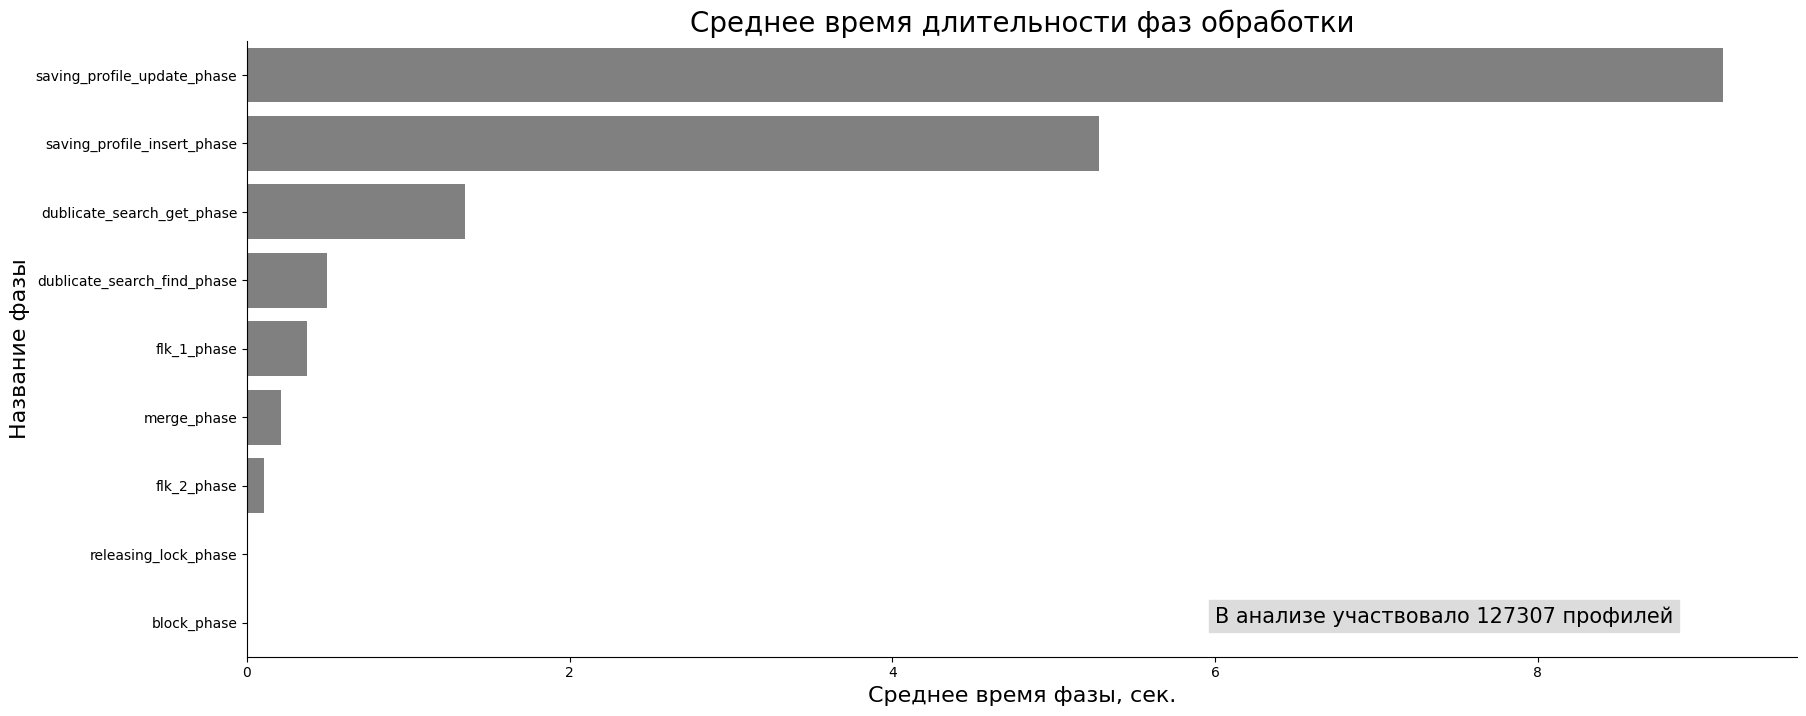

In [60]:
plt.figure(figsize=(20, 8))
phase_mean_time = sns.barplot(data=phase_metrics[~(phase_metrics['Phase'] == 'total_time')]. \
                              sort_values(by='mean', ascending=False), x='mean', y='Phase', color='gray')
plt.title('Среднее время длительности фаз обработки', size=20)
plt.ylabel('Название фазы', size=16)
plt.xlabel('Среднее время фазы, сек.', size=16)
plt.text(6, 8, 'В анализе участвовало 127307 профилей', size=15, backgroundcolor='#DCDCDC')
sns.despine()

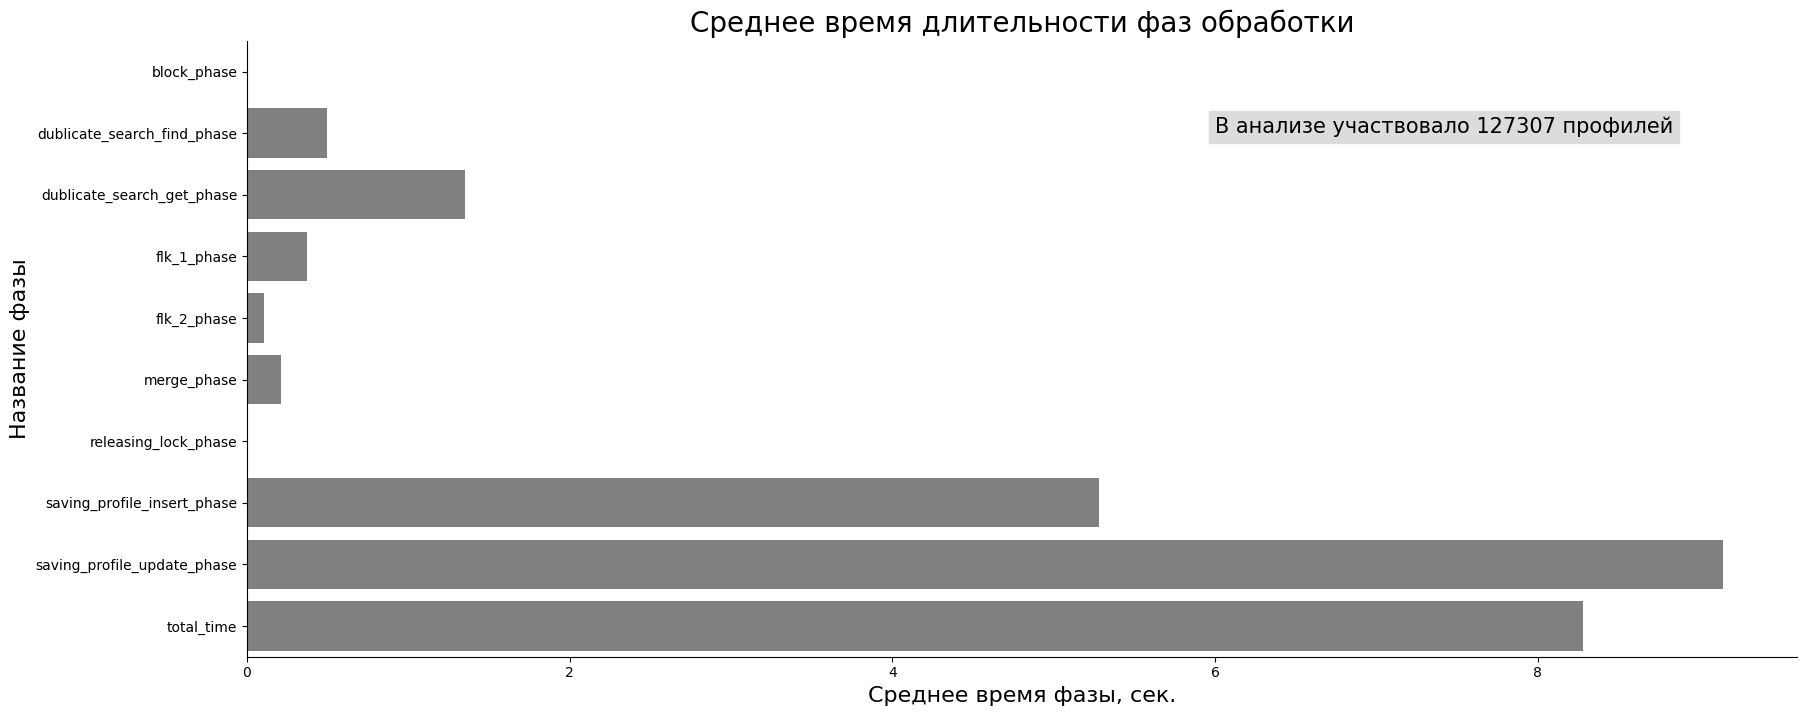

In [61]:
# Копия датафрейма без total_time
phase_metrics_copy = phase_metrics[~(phase_metrics['Phase'] == 'total_time')]

# Зададим кастомную сортировку столбца
custom_order = ['block_phase', 
                'flk_1_phase', 
                'dublicate_search_find_phase', 
                'dublicate_search_get_phase', 
                'merge_phase', 
                'flk_2_phase', 
                'saving_profile_insert_phase', 
                'saving_profile_update_phase', 
                'releasing_lock_phase']

phase_metrics_copy['Phase'] = pd.Categorical(phase_metrics_copy['Phase'], categories=custom_order, ordered=True)
phase_metrics_sorted = phase_metrics.sort_values(by='Phase')

# Отсортировали датафрейм по порядку цикла фаз обработки
phase_metrics_sorted

# Продублируем предыдущий график с новой сортировкой
plt.figure(figsize=(20, 8))
phase_mean_time_sorted = sns.barplot(data=phase_metrics_sorted, x='mean', y='Phase', color='gray')
plt.title('Среднее время длительности фаз обработки', size=20)
plt.ylabel('Название фазы', size=16)
plt.xlabel('Среднее время фазы, сек.', size=16)
plt.text(6, 1, 'В анализе участвовало 127307 профилей', size=15, backgroundcolor='#DCDCDC')
sns.despine()

Распределение total_time

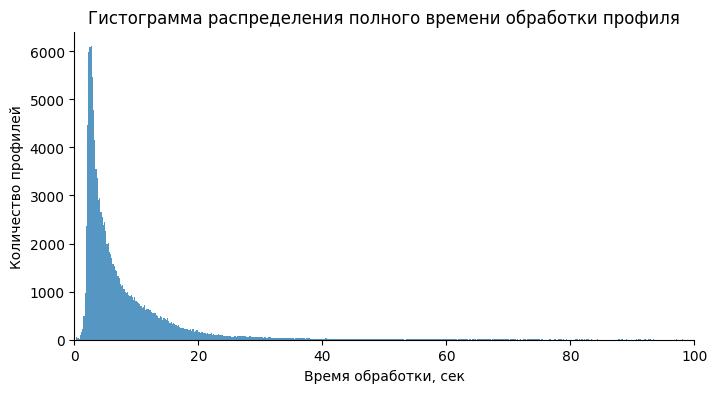

In [62]:
only_total = output_report[output_report['Phase'] == 'total_time']
plt.figure(figsize=(8, 4))
ax = sns.histplot(data=only_total, x='Phase_time', bins=10000)
ax.set_xlim(0, 100)
plt.title('Гистограмма распределения полного времени обработки профиля', size=12)
plt.xlabel('Время обработки, сек', size=10)
plt.ylabel('Количество профилей', size=10)
sns.despine()
plt.show()

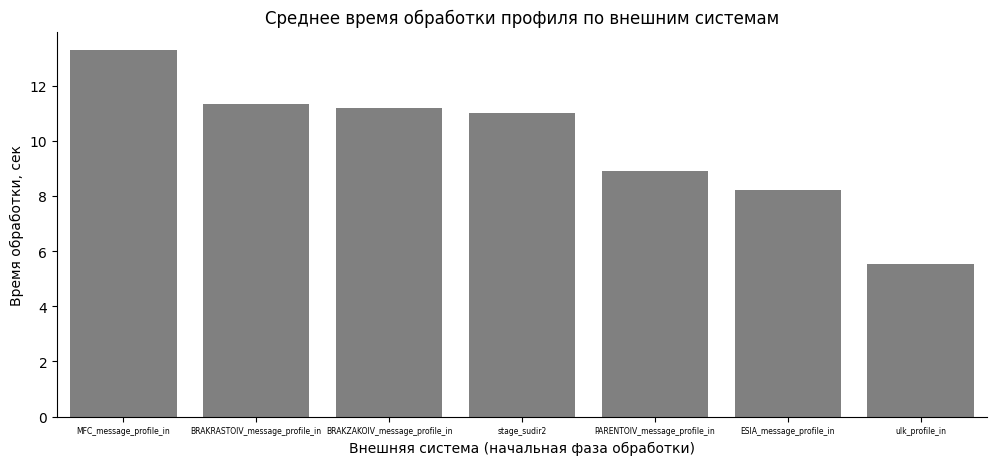

In [70]:
# Среднее время обработки профиля в зависимости от точки входа
time_by_initial = output_report[output_report['Phase'] == 'total_time'] \
                 .groupby('Name_of_initial_phase', as_index=False) \
                 .agg({'Phase_time':'mean'}) \
                 .sort_values(by='Phase_time', ascending=False)
plt.figure(figsize=(12, 5))
time_by_in = sns.barplot(data=time_by_initial, x='Name_of_initial_phase', y='Phase_time', color='gray')
plt.title('Среднее время обработки профиля по внешним системам')
plt.tick_params(axis='x', which='major', labelsize=5.5)
plt.ylabel('Время обработки, сек')
plt.xlabel('Внешняя система (начальная фаза обработки)')
sns.despine()

plt.show()

Найдем долю профилей, обработанных с ошибками. Посмотрим, как часто в процессе возникают баги.

In [104]:
# Добавим датафрейму с профилями с ошибкой 1 столбец с кодом ошибки
error_report['error_code'] = 1

# Соединим таблицу с обработанными профилями с профилями с ошибкой 1
all_error_rep = pd.concat([output_report, error_report], axis=0)

# Считаем долю профилей с ошибкой
error_count = all_error_rep.groupby('error_code', as_index=False).agg({'OperationID':'nunique'})
error_count['share_of_total'] = round((error_count['OperationID']  / sum(error_count['OperationID'])) * 100, 2)
error_count.rename(columns={'OperationID':'id_count'}, inplace=True)

In [105]:
error_count

,error_code,id_count,share_of_total
0,0,120886,88.81
1,1,8818,6.48
2,2,6421,4.72


**10% профилей обрабатывается с различными ошибками**. Однако, из этого пула уже были выброшены профили без входящей фазы, профили с бизнес-ошибками, сооттветственно если бы мы считали общее количество ошибок обработки (без распределения по кодам), то их было бы больше.

Посмотрим, сколько профилей обрабатывается по разным режимам

In [110]:
process_count = output_report.groupby('processing_type', as_index=False).agg(id_count=('OperationID', 'nunique'))
process_count['share_of_total'] = round((process_count['id_count']  / sum(process_count['id_count'])) * 100, 2)

In [111]:
process_count

,processing_type,id_count,share_of_total
0,NoSave,1430,1.12
1,ToUDEnd,125877,98.88


Практически все профили идут по полному режиму обработки.

## Функция для автоматической обработки и вывода информации

In [64]:
#df_name = input()
# ввести имя датафрейма в формате 'df.csv'

In [65]:
def get_phase_for_func(row):
    if row['PhaseID'] in initial_phase:
        if row['PhaseID_num'] == 0:
            return 'initial_phase'
        else:
            return f"initial_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in ending_phase:
        if row['PhaseID_num'] == 0:
            return 'ending_phase'
        else:
            return f"ending_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in block_phase:
        if row['PhaseID_num'] == 0:
            return 'block_phase'
        else:
            return f"block_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in flk_1_phase:
        if row['PhaseID_num'] == 0:
            return 'flk_1_phase'
        else:
            return f"flk_1_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in dublicate_search_phase:
        if '_get' in row['PhaseID']:
            if row['PhaseID_num'] == 0:
                return 'dublicate_search_get_phase'
            else:
                return f"dublicate_search_get_phase_{row['PhaseID_num']}"
        elif '_find_' in row['PhaseID']:
            if row['PhaseID_num'] == 0:
                return 'dublicate_search_find_phase'
            else:
                return f"dublicate_search_find_phase_{row['PhaseID_num']}"
            
    elif row['PhaseID'] in flk_2_phase:
        if row['PhaseID_num'] == 0:
            return 'flk_2_phase'
        else:
            return f"flk_2_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in saving_profile_phase:
        if 'insert' in row['PhaseID']:
            if row['PhaseID_num'] == 0:
                return 'saving_profile_insert_phase'
            else:
                return f"saving_profile_insert_phase_{row['PhaseID_num']}"
        elif 'update' in row['PhaseID']:
            if row['PhaseID_num'] == 0:
                return 'saving_profile_update_phase'
            else:
                return f"saving_profile_update_phase_{row['PhaseID_num']}"
        
    elif row['PhaseID'] in releasing_lock_phase:
        if row['PhaseID_num'] == 0:
            return 'releasing_lock_phase'
        else:
            return f"releasing_lock_phase_{row['PhaseID_num']}"

In [66]:
def get_metrics(df_name):
    report = pd.read_csv(df_name)
    report_copy = report[['OperationID', 'PhaseID', 'Timestamp']]
    report_copy['Timestamp'] = pd.to_datetime(report_copy['Timestamp'], format='%Y-%m-%d-%H-%M-%S-%f')

    initial_phase = ['stage_sudir2', 
                 'ulk_profile_in', 
                 'ESIA_message_profile_in', 
                 'MFC_message_profile_in', 
                 'FATALOIV_message_profile_in',
                 'ROGDOIV_message_profile_in',
                 'BRAKZAKOIV_message_profile_in',
                 'BRAKRASTOIV_message_profile_in', 
                 'PARENTOIV_message_profile_in',
                 'FATAL_message_profile_in',
                 'ROGD_message_profile_in',
                 'PERNAME_message_profile_in',
                 'ERL_message_profile_in',
                 'RR_message_profile_in']

    block_phase = ['lock_start', 'lock_end']

    flk_1_phase = ['stage_to_flk1', 'stage_flk1']

    dublicate_search_phase = ['stage_get_dublicate', 
                          'stage_ud_get_json', 
                          'stage_find_dublicate', 
                          'stage_ud_find_json']

    flk_2_phase = ['stage_to_flk2', 'stage_flk2']

    saving_profile_phase = ['stage_json_insert', 
                        'ud_response_insert', 
                        'stage_json_update', 
                        'ud_response_update']

    releasing_lock_phase = ['unlock_start', 'unlock_end']

    ending_phase = ['stage_sudir2_resp', 
                'ulk_profile_out', 
                'ESIA_message_profile_out', 
                'MFC_message_profile_out', 
                'FATALOIV_message_profile_out',
                'ROGDOIV_message_profile_out', 
                'BRAKZAKOIV_message_profile_out', 
                'BRAKRASTOIV_message_profile_out',
                'PARENTOIV_message_profile_out', 
                'FATAL_message_profile_out', 
                'ROGD_message_profile_out',
                'PERNAME_message_profile_out',
                'ERL_message_profile_out',
                'RR_message_profile_out']

    validation_phase = ['stage_ksrd_valid_save', 
                    'extval_from_ksrd_asur_msg'] 

    ignore_phase = ['locked_by_merge'] 

    error_business_phase = ['skip_new_deleted', 'stage_cannot_del_val', 'stage_update_rip']

    error_phase = ['exception', 'stoplist_response', 'stoplist_response_org']
    
    unknow_phase = []
    all_phase = (initial_phase + 
             block_phase + 
             flk_1_phase + 
             dublicate_search_phase +
             flk_2_phase + 
             saving_profile_phase + 
             releasing_lock_phase + 
             ending_phase + 
             validation_phase +
             ignore_phase + 
             error_business_phase +
             error_phase)
    for phase in report_copy['PhaseID']:
        if phase in all_phase:
            continue
        else:
            if phase in unknow_phase:
                continue
            else:
                unknow_phase.append(phase)
                
    ignore_phase += unknow_phase

    error_report = report_copy[report_copy['PhaseID'].isin(error_phase)]
    operation_id_errors = error_report['OperationID'].to_list()
    report_copy = report_copy[~report_copy['OperationID'].isin(operation_id_errors)]
    profile_with_in = report_copy[report_copy['PhaseID'].isin(initial_phase)].OperationID.to_list()
    report_copy = report_copy[report_copy['OperationID'].isin(profile_with_in)]
    profile_error_business = report_copy[report_copy['PhaseID'].isin(error_business_phase)].OperationID.to_list()
    report_copy = report_copy[~report_copy['OperationID'].isin(profile_error_business)]
    report_copy_error_2 = report_copy[report_copy['PhaseID'].isin(validation_phase)]
    operation_id_error_2 = list(report_copy_error_2.OperationID.unique())
    end_time = report_copy[report_copy['PhaseID'].isin(ending_phase)] \
           .groupby(['OperationID', 'PhaseID'], as_index=False) \
           .agg({'Timestamp':'max'})[['OperationID', 'Timestamp']]
    end_time.rename(columns={'Timestamp':'max_time'}, inplace=True)
    report_copy = pd.merge(report_copy, end_time, how='left', on='OperationID')
    report_copy = report_copy[report_copy['Timestamp'] <= report_copy['max_time']] \
             .drop_duplicates(subset=['OperationID', 'PhaseID', 'Timestamp'])
    report_copy = report_copy[['OperationID', 'PhaseID', 'Timestamp']]
    report_copy_clean = report_copy[~report_copy['PhaseID'].isin(ignore_phase)]

    report_copy_clean['PhaseID_num'] = report_copy_clean.groupby(['OperationID', 'PhaseID']).cumcount()
    # вот тут важно проверить!
    report_copy_clean['Phase'] = report_copy_clean.apply(get_phase_for_func, axis=1)
    sorted_report = report_copy_clean.sort_values(by=['OperationID', 'Timestamp'])[['OperationID', 'PhaseID', 'Timestamp', 'Phase']]
    sorted_report['time_diff'] = sorted_report.groupby(['OperationID', 'Phase'])['Timestamp'].diff()
    sorted_report['time_diff'] = np.where((sorted_report['Phase'] == 'initial_phase') | (sorted_report['Phase'] == 'ending_phase'), 
                                     sorted_report['Timestamp'],
                                     sorted_report['time_diff'])
    report_for_pivot = sorted_report.dropna(subset=['time_diff']).reset_index()
    report_pivot = sorted_report \
              .dropna(subset=['time_diff']) \
              .reset_index() \
              .pivot(index='OperationID', columns='Phase', values='time_diff')
    report_pivot['total_time'] = report_pivot['ending_phase'] - report_pivot['initial_phase']

    return report_pivot

In [67]:
get_metrics(df_name)

NameError: name 'df_name' is not defined